## S&P Global - CORE2LOG: AUTOMATIC ROCK CLASSIFICATION
### Misael M. Morales, Carlos Torres-Verdin, and Michael Pyrcz, UT-Austin; Murray Christie, Vladimir Rabinovich, S&P Global
#### 2024, Digital Reservoir Characterization Technology (DiReCT)
***

In [1]:
from auto_rock_classification import *

***
# CORE ANALYSIS
***

In [2]:
all_data = pd.read_csv('Data/GULFCOAST & TX CORE.csv', low_memory=False)
all_data['PORO'] = all_data['POROSITY'].fillna(all_data['EFFECTIVE_POROSITY'])
all_data['PERM'] = all_data['K90'].fillna(all_data['KMAX']).fillna(all_data['KVERT'])
all_data = all_data.replace(0., np.nan, inplace=False)
all_data = all_data.dropna(subset=['PORO', 'PERM'])

In [60]:
mycols = ['PORO','PERM','INTERVAL_DEPTH','SURFACE_LATITUDE','SURFACE_LONGITUDE']
well_core = {}
uwi_clean = []
for u, data in all_data.groupby('UWI'):
    if data.shape[0] > 30:
        well_core[str(u)] = data[mycols].set_index('INTERVAL_DEPTH')
        uwi_clean.append(str(u))

In [642]:
def c2l_dashboard(well_number:int=0, method='leverett',
                    n_classes=None, cutoffs=None, random_state=2024,
                    kexp=0.588, texp=0.732, pexp=0.864,
                    colors=['firebrick', 'dodgerblue', 'seagreen', 'gold', 'black'],
                    markers=['o', 's', 'D', '^', 'v'],
                    phimin=None, phimax=None, kmin=None, kmax=None,
                    s1=10, sw=80, s2=50, ms=30, alpha=0.25, alphag=0.33,
                    cmap0='plasma', cmap='jet', figsize=(15,8), showfig=True, **kwargs
                    ):
    
    if n_classes is None and cutoffs is not None:
        n_classes = len(cutoffs)
        assert len(cutoffs) < 6, 'Maximum number of classes is 5'
    elif n_classes is not None and cutoffs is None:
        if method=='lorenz':
            cutoffs = np.linspace(0, 3, n_classes)
        else:
            cutoffs = np.linspace(0.1, 1000, n_classes+1)
        assert n_classes < 6, 'Maximum number of classes is 5'
    else:
        raise ValueError('You must provide either n_classes or cutoffs, but not both')
    
    if method not in ['kmeans', 'gmm', 'leverett', 'winland', 'lorenz']:
        raise ValueError('Invalid method. Choose between ("kmeans", "gmm", "leverett", "winland" or "lorenz")')
    
    lati, longi = all_data['SURFACE_LATITUDE'], all_data['SURFACE_LONGITUDE']
    ymin, ymax  = lati.min()-0.5, lati.max()+0.5
    xmin, xmax  = longi.min()-1,  longi.max()+1

    print('-'*65+'\n'+'Initializing Automatic Rock Classification Dashboard'+'\n'+'-'*65)
    print('Well #{} | UWI: {} | LAT: {} | LONG: {}'.format(well_number, uwi_clean[well_number], lati[well_number], longi[well_number]))
    print('Method: {} | Number of Classes: {} | Cutoffs: {}'.format(method, n_classes, cutoffs))
    print('-'*65+'\n')

    d = well_core[uwi_clean[well_number]]
    x, y = d['SURFACE_LONGITUDE'], d['SURFACE_LATITUDE']
    p, k, logk = d['PORO']/100, d['PERM'], np.log10(d['PERM'])
    X = pd.DataFrame({'PORO':p, 'PERM':logk})
    d.loc[:,'CLASS'] = np.zeros_like(p)

    if phimin is None:
        phimin = p.min()
    if phimax is None:
        phimax = p.max()
    if kmin is None:
        kmin = k.min()
    if kmax is None:
        kmax = k.max()

    lin_poro = np.linspace(0, phimax, 50)
    lin_perm_low, lin_perm_med, lin_perm_high = [], [], []
    lin_X = pd.DataFrame({'PORO':np.linspace(0, phimax, len(d)), 'PERM':np.linspace(kmin, kmax, len(d))})

    if method=='kmeans':
        lab = 'K-Means Class'
        clf = make_pipeline(MinMaxScaler(), KMeans(n_clusters=n_classes, random_state=random_state)).fit(X)
        d['CLASS'] = clf.predict(X) + 1
        v = clf.predict(lin_X) + 1
   
    elif method=='gmm':
        lab = 'GMM Class'
        clf = make_pipeline(MinMaxScaler(), GaussianMixture(n_components=n_classes, random_state=random_state)).fit(X)
        d['CLASS'] = clf.predict(X) + 1
        v = clf.predict(lin_X) + 1
   
    elif method=='leverett':
        cutoffs = [0] + cutoffs
        lab = 'Leverett $\sqrt{k/\phi}$'
        mask = []
        color_centers = []
        v = np.sqrt(k/p)
        def leverett_fun(w, l=lin_poro):
            return (w**2 * l)
        for i in range(len(cutoffs)-1):
            mask.append(np.logical_and(v>=cutoffs[i], v<=cutoffs[i+1]))
            color_centers.append(np.mean([cutoffs[i], cutoffs[i+1]]))
        for i in range(len(color_centers)):
            lin_perm_low.append(leverett_fun(cutoffs[i]))
            lin_perm_med.append(leverett_fun(color_centers[i]))
            lin_perm_high.append(leverett_fun(cutoffs[i+1]))
        for i, m in enumerate(mask):
            d.loc[m, 'CLASS'] = int(i+1)

    elif method=='winland':
        cutoffs = [0] + cutoffs
        lab = 'Winland $R_{35}$'
        mask = []
        color_centers = []
        v = k**kexp * 10**texp / p**pexp
        def winland_fun(r35, l=lin_poro):
            return ((r35 * l**pexp) / 10**texp)**(1/kexp)
        for i in range(len(cutoffs)-1):
            mask.append(np.logical_and(v>=cutoffs[i], v<=cutoffs[i+1]))
            color_centers.append(np.mean([cutoffs[i], cutoffs[i+1]]))
        for i in range(len(color_centers)):
            lin_perm_low.append(winland_fun(cutoffs[i]))
            lin_perm_med.append(winland_fun(color_centers[i]))
            lin_perm_high.append(winland_fun(cutoffs[i+1]))
        for i, m in enumerate(mask):
            d.loc[m, 'CLASS'] = int(i+1)

    elif method=='lorenz':
        lab = 'Lorenz Class'
        cp = np.cumsum(p)/p.sum()
        ck = np.cumsum(k)/k.sum()
        cv = np.cumsum(np.sort(ck))/np.cumsum(np.sort(cp)).max()
        v  = np.concatenate([[0], np.diff(ck)/np.diff(cp)])
        mask = []
        for i in range(len(cutoffs)-1):
            mask.append((v>=cutoffs[i]) & (v<=cutoffs[i+1]))
        for i, m in enumerate(mask):
            d.loc[m, 'CLASS'] = int(i+1)
    
    else:
        raise ValueError('Invalid method. Choose between ("kmeans", "gmm", "leverett", "winland" or "lorenz")')
    
    z = np.arange(d.index[0], d.index[-1]+15, step=0.5)
    t = np.zeros_like(z)
    class_values = d['CLASS'].values
    for i in range(len(t)):
        t[i] = class_values[np.argmin(np.abs(d.index-z[i]))]
    for i in range(len(t)):
        t[i] = t[i-1] if t[i]==0 else t[i]

    fig = plt.figure(figsize=figsize)
    gs  = GridSpec(6, 6, figure=fig)

    ax1 = fig.add_subplot(gs[:3, :3])
    ax2 = fig.add_subplot(gs[3:, :3])
    ax3 = fig.add_subplot(gs[:, 3])
    ax4 = fig.add_subplot(gs[:, 4])
    ax5 = fig.add_subplot(gs[:, 5])
    ax4.sharey(ax3); ax5.sharey(ax3)
    axs = [ax1, ax2, ax3, ax4, ax5]
    
    # Spatial plot of core data
    im1 = ax1.scatter(longi, lati, c=all_data['PORO']/100, cmap=cmap0, s=s1, vmax=0.35)
    ax1.set(xlabel='Surface Longitude', ylabel='Surface Latitude')
    cb1 = plt.colorbar(im1); cb1.set_label('Porosity [v/v]', rotation=270, labelpad=15)
    ax1.scatter(x, y, marker='*', c='k', s=sw)
    ax1.vlines(x, ymin, y, color='k', alpha=alpha)
    ax1.hlines(y, xmin, x, color='k', alpha=alpha)
    ax1.set_xlim(xmin, xmax); ax1.set_ylim(ymin, ymax)
    ax1.patch.set_facecolor('lightgray')

    # poro-vs-perm with classification values
    if method=='leverett' or method=='winland':
        im2 = ax2.scatter(p, k, c=v, cmap=cmap, s=s2, edgecolor='k', linewidth=0.5)
        cb = plt.colorbar(im2); cb.set_label(lab, rotation=270, labelpad=15)
        ax2.set(xlim=(0, phimax))
        for i, m in enumerate(mask):
            ax2.plot(lin_poro, lin_perm_med[i], c=colors[i])
            ax2.fill_between(lin_poro, lin_perm_low[i], lin_perm_high[i], color=colors[i], alpha=alpha)
    elif method=='lorenz':
        colors = colors[:len(cutoffs)]
        cmap2 = ListedColormap(colors)
        im2 = ax2.scatter(p, k, c=v, cmap=cmap, s=s2, edgecolor='k', linewidth=0.5)
        cb = plt.colorbar(im2); cb.set_label(lab, rotation=270, labelpad=15)
        ax21 = ax2.twinx().twiny()
        #ax21.scatter(cv, np.sort(ck), c=cv, cmap=cmap2)
        ax21.scatter(np.sort(cp), np.sort(ck), c=mask, cmap=cmap2)
        ax21.axline([0,0],[1,1], c='k', ls='--')
        ax21.set(xlim=(-0.01,1.025), ylim=(-0.025,1.025))
    else:
        colors = colors[:len(cutoffs)]
        cmap2 = ListedColormap(colors)
        im2 = ax2.scatter(p, k, c=d['CLASS'], cmap=cmap2, s=s2, edgecolor='k', linewidth=0.5)
        cb = plt.colorbar(im2, ax=ax2); cb.set_label(lab, rotation=270, labelpad=15)
        cb.set_ticks(np.arange(1, n_classes+1)); cb.set_ticklabels(np.arange(1, n_classes+1))
    ax2.set_yscale('log')
    ax2.set(xlabel='Porosity [v/v]', ylabel='Permeability [mD]')
    
    # Core porosity vs depth
    for i in range(n_classes):
        c = d['CLASS']
        if method!='lorenz':
            ax3.scatter(p[c==i+1], d.index[c==i+1], c=colors[i], marker=markers[i], s=ms, edgecolor='gray', lw=0.5)
        else:
            ax3.scatter(p[c==i], d.index[c==i], c=colors[i], marker=markers[i], s=ms, edgecolor='gray', lw=0.5)
    ax3.set(xlabel='Porosity [v/v]', ylabel='Depth [ft]')
    ax3.invert_yaxis()

    # Core permeability vs depth
    for i in range(n_classes):
        c = d['CLASS']
        if method!='lorenz':
            ax4.scatter(k[c==i+1], d.index[c==i+1], c=colors[i], marker=markers[i], s=ms, edgecolor='gray', lw=0.5)
        else:
            ax4.scatter(k[c==i], d.index[c==i], c=colors[i], marker=markers[i], s=ms, edgecolor='gray', lw=0.5)
    ax4.set(xlabel='Permeability [mD]')
    ax4.set(xscale='log')

    # Rock Class vs depth
    ax5.set(xlabel='{} Rock Class'.format(method.capitalize()))
    ax5.set_xticks(np.arange(1, n_classes+1)); ax5.set_xticklabels(np.arange(1, n_classes+1))
    ax5.set(xlim=(0.25, n_classes+0.25))
    
    for i in range(n_classes):
        ax5.fill_betweenx(d.index, 0, d['CLASS'], where=(d['CLASS']==i), color=colors[i-1])
    


    fig.suptitle('Well Rock Classification | UWI: {} | {} method'.format(uwi_clean[well_number], method.capitalize()), weight='bold')
    for ax in axs:
        ax.grid(True, which='both', alpha=alphag)
    plt.tight_layout()
    plt.savefig('figures/ARC_dashboard_{}.png'.format(uwi_clean[well_number]), dpi=300)
    plt.show() if showfig else None

    return d

-----------------------------------------------------------------
Initializing Automatic Rock Classification Dashboard
-----------------------------------------------------------------
Well #867 | UWI: 42261305230000 | LAT: 27.98 | LONG: -93.52
Method: leverett | Number of Classes: 3 | Cutoffs: [6, 20, 80]
-----------------------------------------------------------------



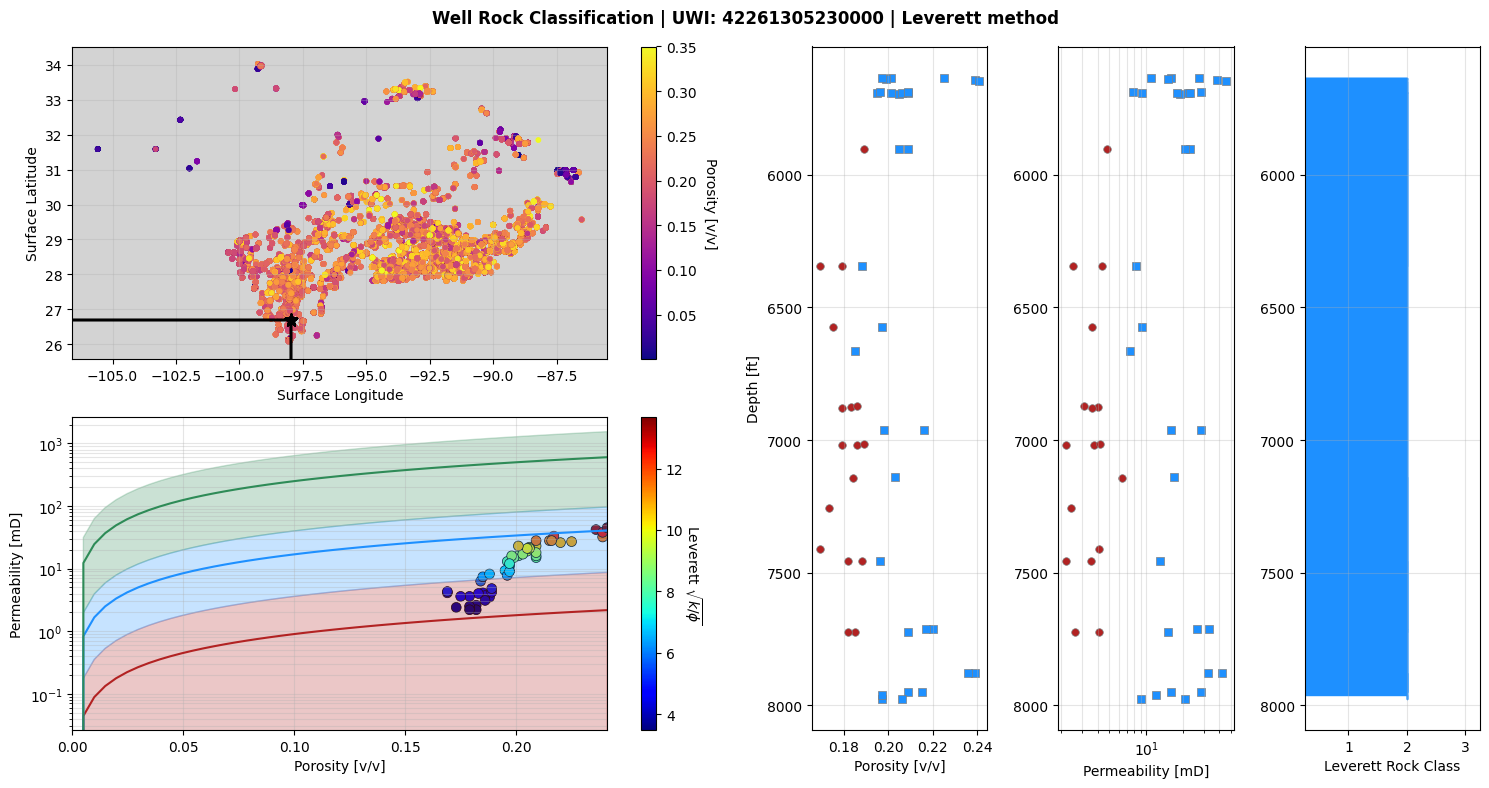

In [643]:
d = c2l_dashboard(867, method='leverett', cutoffs=[6, 20, 80])

***
# END